# Methoden en Technieken -- Blok 3

## Datapunt Opdracht

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- B2: Je stelt op basis van requirements een geschikte **architectuur** voor een AI-oplossing op en selecteert daarvoor passende AI-technieken, gebruik makend van **machine learning**, **deep learning**, kennisrepresentatie, computer vision, natural language processing en robotica.

- B4: **Je ontwikkelt, traint en evalueert een AI-model** volgens een iteratief proces.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria** die in het vakgebied erkend worden waaronder robustness, **performance**, scalability, explainability, model complexity en resource demand.

## De opdracht

Maak een reinforcement learning model dat $10 \times 10$ GridWorld leert spelen in **random** modus, met een *policy gradient* methode. (Hint: Hoofdstuk 3 van *Deep Reinforcement Learning in Action* geeft een paar suggesties hoe je met de $10 \times 10$ invoer om kan gaan.)
- Maak een keuze uit de verschillende *policy gradient* technieken die in de les behandeld zijn en licht deze kort en bondig toe.
- Je zal een aantal iteraties doorlopen om uiteindelijk een goed (of zo goed mogelijk, gegeven de tijd) netwerk te krijgen, licht vooral de keuzes die je maakt voor je uiteindelijke model kort en bondig toe. Begin simpel (en denk na over wat simpel in deze context betekent.)
- Besluit hoe je je model evalueert (licht deze keuze kort en bondig toe) en geef de resultaten.

## Praktische Tips:
- Gebruik de versie van GridWorld die op DLO staat
- Combineer de code van les 8 ($Q$ learning op GridWorld) en les 9 (policy gradient) of later
  - Je zult hier de **env.step** in les 9 moeten vervangen door **game.makeMove** uit les 8, etc...
  - Let goed op de beloningen in deze codes, in CartPole was de beloning de duur van het spel, maar in GridWorld krijg je deze uit het spel.

### Initial Setup: Import Libraries and Environment

In [ ]:
from GridBoard import *
from Gridworld import Gridworld
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import namedtuple
from IPython.display import HTML, display


### Modelstructuur: Implementatie van een REINFORCE-agent

In dit project heb ik een REINFORCE-agent gebouwd: een policy gradient methode die direct een kansverdeling over acties leert, in plaats van Q-waarden zoals bij value-based methoden (zie les 10). De agent wordt getraind om een $10 \times 10$ GridWorld te navigeren waarin hij een doel moet bereiken en valkuilen moet vermijden.

Instellingen en input
De agent is geconfigureerd met een vaste set hyperparameters zoals omgevinggrootte, learning rate, gamma en het aantal episodes. Voor de baseline  gebruik ik een dummy state — een constante input van [[0.0]]. Dit betekent dat de agent geen informatie uit de omgeving krijgt, en puur leert op basis van de beloningen die hij ontvangt. Dit dient als een eenvoudige nulmeting om te zien of hij alleen op basis van feedback een strategie kan ontwikkelen.

Beloningsstructuur
De beloningsfunctie is handmatig opgesteld op basis van hoe de GridWorld werkt. In de omgeving zijn vaste posities gedefinieerd voor een doel (Goal), een valkuil (Pit), en de speler (Player). De beloningen zijn als volgt gekozen:

+10 als de agent het doel bereikt,

-10 bij een val in een pit,

-1 als hij stilstaat (geen beweging),

+0.5 voor het ontdekken van een nieuwe plek,

+0.1 voor het herhalen van een eerder bezochte locatie.

Deze waarden zijn bedoeld om de agent te stimuleren richting het doel te bewegen, vallen te vermijden, en nieuwe paden te verkennen.

Neuraal netwerk
Het beleid van de agent wordt gemodelleerd met een simpel feedforward netwerk met één verborgen laag van 128 neuronen (ReLU activatie), en een softmax-uitgang om een kansverdeling over vier acties te geven: omhoog, omlaag, links, rechts. De acties worden gekozen op basis van deze kansen, dus niet deterministisch maar probabilistisch.

Trainen en testen
Tijdens het trainen verzamelt de agent alle staten, acties en beloningen per episode. Na afloop van een episode worden de returns berekend, en gebruikt om het netwerk bij te werken via een policy gradient update. Dit gebeurt met het klassieke REINFORCE algoritme (zoals behandeld in les 10). Ik heb ook een testfunctie toegevoegd die het model evalueert in een nieuwe, willekeurige omgeving. De test maakt gebruik van de dummy state en toont of het beleid generaliseert naar nieuwe situaties.

Visualisaties
Om de prestaties van het model te evalueren, heb ik grafieken toegevoegd die het verloop van de reward, succesratio en aantal stappen per episode laten zien. Ook visualiseer ik het pad van de agent in de omgeving, en vergelijk ik het gedrag bij successen en mislukkingen. Deze inzichten helpen om het leerproces goed te volgen.

In [ ]:
Config = namedtuple('Config', ['env_size', 'hidden_size', 'lr', 'gamma', 'episodes', 'max_steps'])

def dummy_state(_env):
    return np.array([[0.0]], dtype=np.float32)

def reward_baseline(env, old, new, visited):
    goal = env.board.components['Goal'].pos
    pit = env.board.components['Pit'].pos

    # Reward logic based on the agent's position
    if new == goal:
        return 10
    elif new == pit:
        return -10
    elif new == old:
        return -1
    elif new not in visited:
        return 0.5
    else:
        return 0.1

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Neural network architecture
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

class ReinforceAgent:
    def __init__(self, state_size, action_size, hidden_size, lr, gamma):
        # Initialize policy network and optimizer
        self.policy = PolicyNetwork(state_size, hidden_size, action_size)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}
        self.reset_episode()

    def reset_episode(self):
        # Reset histories for a new episode
        self.state_history = []
        self.action_history = []
        self.reward_history = []

    def select_action(self, state):
        # Select action based on policy probabilities
        probs = self.policy(torch.FloatTensor(state))
        action = np.random.choice(4, p=probs.detach().numpy().squeeze())
        return action

    def store_transition(self, state, action, reward):
        # Store state, action, and reward for the episode
        self.state_history.append(state)
        self.action_history.append(action)
        self.reward_history.append(reward)

    def update_policy(self):
        # Compute returns and update policy using REINFORCE algorithm
        returns, G = [], 0
        for r in reversed(self.reward_history):
            G = r + self.gamma * G
            returns.insert(0, G)

        states = torch.FloatTensor(np.concatenate(self.state_history))
        actions = torch.LongTensor(self.action_history)
        returns = torch.FloatTensor(returns)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        probs = self.policy(states)
        selected_probs = probs.gather(1, actions.unsqueeze(1)).squeeze()
        loss = -torch.sum(torch.log(selected_probs) * returns)

        # Backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.reset_episode()
        return loss.item()

    def get_policy(self, state):
        # Get action probabilities for a given state
        with torch.no_grad():
            return self.policy(torch.FloatTensor(state)).squeeze().numpy()

def train_agent(config, reward_fn, state_fn):
    # Initialize agent and training variables
    agent = ReinforceAgent(1 if state_fn == dummy_state else 400, 4, config.hidden_size, config.lr, config.gamma)
    scores, wins = [], []
    reward_stats = {}
    steps_log, success_steps, fail_steps = [], [], []

    for episode in tqdm(range(config.episodes)):
        env = Gridworld(size=config.env_size, mode='random')
        state = state_fn(env)
        visited = set()
        ep_reward, win = 0, 0

        for step in range(config.max_steps):
            # Agent selects action and interacts with the environment
            action = agent.select_action(state)
            old = env.board.components['Player'].pos
            env.makeMove(agent.action_set[action])
            new = env.board.components['Player'].pos

            # Compute reward and store transition
            reward = reward_fn(env, old, new, visited)
            visited.add(new)
            reward_stats[reward] = reward_stats.get(reward, 0) + 1

            next_state = state_fn(env)
            agent.store_transition(state, action, reward)
            ep_reward += reward

            # Check if the episode ends
            if new in [env.board.components['Goal'].pos, env.board.components['Pit'].pos]:
                win = int(new == env.board.components['Goal'].pos)
                break

            state = next_state

        # Update policy after each episode
        agent.update_policy()
        scores.append(ep_reward)
        wins.append(win)
        steps_log.append(step + 1)
        if win == 1:
            success_steps.append(step + 1)
        else:
            fail_steps.append(step + 1)

    return agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps

def test_agent(agent, env_size=10):
    # Test the trained agent in a new environment
    env = Gridworld(size=env_size, mode='random')
    state = dummy_state(env)
    visited, total_reward = set(), 0

    print(env.display())
    for step in range(50):
        # Agent selects the best action based on policy
        probs = agent.get_policy(state)
        action = np.argmax(probs)
        old = env.board.components['Player'].pos
        env.makeMove(agent.action_set[action])
        new = env.board.components['Player'].pos

        # Compute reward and display environment
        reward = reward_baseline(env, old, new, visited)
        visited.add(new)
        total_reward += reward
        print(f"Step {step+1}, Action: {agent.action_set[action]}, Reward: {reward:.2f}")
        print(env.display())

        # Check if the episode ends
        if new in [env.board.components['Goal'].pos, env.board.components['Pit'].pos]:
            break
        state = dummy_state(env)

    print(f"Test klaar in {step+1} stappen met reward {total_reward:.2f}")

def moving_average(data, window_size=50):
    # Compute moving average for smoothing
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_success_fail_steps(success_steps, fail_steps):
    # Plot histogram of steps for successes and failures
    plt.figure(figsize=(8, 5))
    plt.hist(success_steps, bins=30, alpha=0.7, label='Successen', color='green')
    plt.hist(fail_steps, bins=30, alpha=0.7, label='Mislukkingen', color='red')
    plt.axvline(np.mean(success_steps), color='green', linestyle='dashed', linewidth=1.5,
                label=f'Gem. succes: {np.mean(success_steps):.1f}')
    plt.axvline(np.mean(fail_steps), color='red', linestyle='dashed', linewidth=1.5,
                label=f'Gem. fail: {np.mean(fail_steps):.1f}')
    plt.title('Aantal stappen bij successen vs. mislukkingen')
    plt.xlabel('Aantal stappen')
    plt.ylabel('Frequentie')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_results(scores, success_log, steps_log=None):
    # Plot training results: rewards, success rate, and steps
    num_plots = 3 if steps_log is not None else 2
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 12))

    axs[0].plot(moving_average(scores, 50), label='Gem. reward (rolling mean)')
    axs[0].set_title('REINFORCE op Gridworld - Gemiddelde Reward')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].grid(True)
    axs[0].legend()

    window_size = 500
    if len(success_log) >= window_size:
        success_rate = [
            np.mean(success_log[i:i+window_size]) * 100
            for i in range(0, len(success_log) - window_size + 1)
        ]
        axs[1].plot(range(window_size, len(success_log)+1), success_rate, label='Succesrate (rolling %)')
        axs[1].set_title('Succesrate per 500 episodes')
        axs[1].set_xlabel('Episode')
        axs[1].set_ylabel('Succesrate (%)')
        axs[1].set_ylim(0, 100)
        axs[1].grid(True)
        axs[1].legend()
    else:
        axs[1].text(0.5, 0.5, f'Not enough data for success rate plot (need {window_size} episodes)',
                   horizontalalignment='center', verticalalignment='center')

    if steps_log is not None:
        axs[2].plot(moving_average(steps_log, 100), color='orange', label='Gem. aantal stappen (rolling mean)')
        axs[2].set_title('Gemiddeld aantal stappen per episode')
        axs[2].set_xlabel('Episode')
        axs[2].set_ylabel('Aantal stappen')
        axs[2].grid(True)
        axs[2].legend()

    plt.tight_layout()
    plt.show()


### Animatie 
 er is een animatie toegevoegd van een enkele testepisode. Deze is bedoeld om het gedrag van de agent visueel te verkennen en geeft een indruk van hoe het geleerde beleid zich vertaalt naar beweging in de omgeving. De animatie wordt verder niet gebruikt als evaluatiemaatstaf, omdat één episode geen representatief beeld geeft van de algemene prestaties van het model. Het diende vooral als visuele controle uit interesse.

In [3]:
def animate_agent_path(agent, env_size=10, state_fn=None):
    # Controleer of een state_fn is meegegeven, anders geef een foutmelding.
    if state_fn is None:
        raise ValueError("Je moet een state_fn meegeven aan animate_agent_path()")

    # Maak een nieuwe Gridworld-omgeving met de opgegeven grootte en willekeurige startpositie.
    env = Gridworld(size=env_size, mode='random')
    # Verkrijg de startstaat van de omgeving met behulp van de meegegeven state_fn.
    state = state_fn(env)
    # Initialiseer een lijst om de posities van de agent bij te houden.
    agent_path = []
    # Initialiseer een set om bezochte posities bij te houden.
    visited = set()

    # Itereer maximaal 50 stappen om de beweging van de agent te simuleren.
    for _ in range(50):
        # Selecteer een actie op basis van het huidige beleid van de agent.
        action = agent.select_action(state)
        # Voer de actie uit in de omgeving.
        env.makeMove(agent.action_set[action])
        # Verkrijg de nieuwe positie van de agent.
        pos = env.board.components['Player'].pos
        # Voeg de nieuwe positie toe aan het pad van de agent.
        agent_path.append(pos)

        # Stop de simulatie als de agent het doel of de valkuil bereikt.
        if pos == env.board.components['Goal'].pos or pos == env.board.components['Pit'].pos:
            break
        # Voeg de huidige positie toe aan de set van bezochte posities.
        visited.add(pos)
        # Update de huidige staat van de omgeving.
        state = state_fn(env)

    # Verkrijg de positie van het doel in de omgeving.
    goal_pos = env.board.components['Goal'].pos
    # Verkrijg de positie van de valkuil in de omgeving.
    pit_pos = env.board.components['Pit'].pos

    # Maak een nieuwe figuur en as voor de visualisatie.
    fig, ax = plt.subplots(figsize=(5, 5))
    # Stel de limieten van de x-as in op basis van de omgeving.
    ax.set_xlim(-0.5, env_size - 0.5)
    # Stel de limieten van de y-as in op basis van de omgeving.
    ax.set_ylim(-0.5, env_size - 0.5)
    # Stel de ticks van de x-as in op de grootte van de omgeving.
    ax.set_xticks(range(env_size))
    # Stel de ticks van de y-as in op de grootte van de omgeving.
    ax.set_yticks(range(env_size))
    # Voeg een raster toe aan de plot.
    ax.grid(True)

    # Voeg een blauwe stip toe om de agent te representeren, maar zonder data (leeg).
    agent_dot, = ax.plot([], [], 'bo', markersize=12)
    # Voeg een groene stip toe om het doel te representeren.
    ax.plot(goal_pos[0], goal_pos[1], 'go', markersize=12, label='Goal')
    # Voeg een rode stip toe om de valkuil te representeren.
    ax.plot(pit_pos[0], pit_pos[1], 'ro', markersize=12, label='Pit')
    # Voeg een legenda toe om de betekenis van de stippen uit te leggen.
    ax.legend()

    # Definieer een functie om de positie van de agent bij te werken tijdens de animatie.
    def update(frame):
        # Haal de positie van de agent op voor het huidige frame.
        pos = agent_path[frame]
        # Update de positie van de blauwe stip (agent).
        agent_dot.set_data(pos[0], pos[1])
        # Retourneer de bijgewerkte stip.
        return agent_dot,

    # Maak een animatie met behulp van de update-functie en het pad van de agent.
    ani = animation.FuncAnimation(
        fig, update, frames=len(agent_path), interval=300, blit=True, repeat=False
    )
    # Sluit de plot om dubbele weergave in Jupyter Notebook te voorkomen.
    plt.close()
    # Retourneer de animatie.
    return ani



### Iteratie 0 (baseline: dummy state + baseline reward)

In de eerste iteratie is gekozen voor een eenvoudige configuratie zonder optimalisaties. De agent gebruikt een dummy state als input, wat betekent dat hij geen informatie ontvangt over zijn positie of de omgeving. De beloningsstructuur is standaard: het bereiken van het doel levert +10 op, vallen in een pit -10, stilstand wordt bestraft met -1, en nieuwe of herhaalde posities worden licht beloond. Met een gamma van 0.99 worden toekomstige beloningen licht gedisconteerd, passend bij een episode-gebaseerde benadering zoals REINFORCE. Deze iteratie vormt het uitgangspunt waarop verdere verbeteringen worden gebaseerd.

In [4]:
torch.manual_seed(2025)
np.random.seed(2025)

iter0_config = Config(env_size=10, hidden_size=128, lr=0.01, gamma=0.99, episodes=5000, max_steps=200)

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter0_config, reward_fn=reward_baseline, state_fn=dummy_state
)


100%|██████████| 5000/5000 [02:13<00:00, 37.33it/s]


### Evaluatie van het Baseline Model


--- Test baseline ---
[['P' ' ' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 1, Action: r, Reward: 0.50
[[' ' 'P' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
Step 2, Action: r, Reward: -10.00
[[' ' ' ' '-' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' 

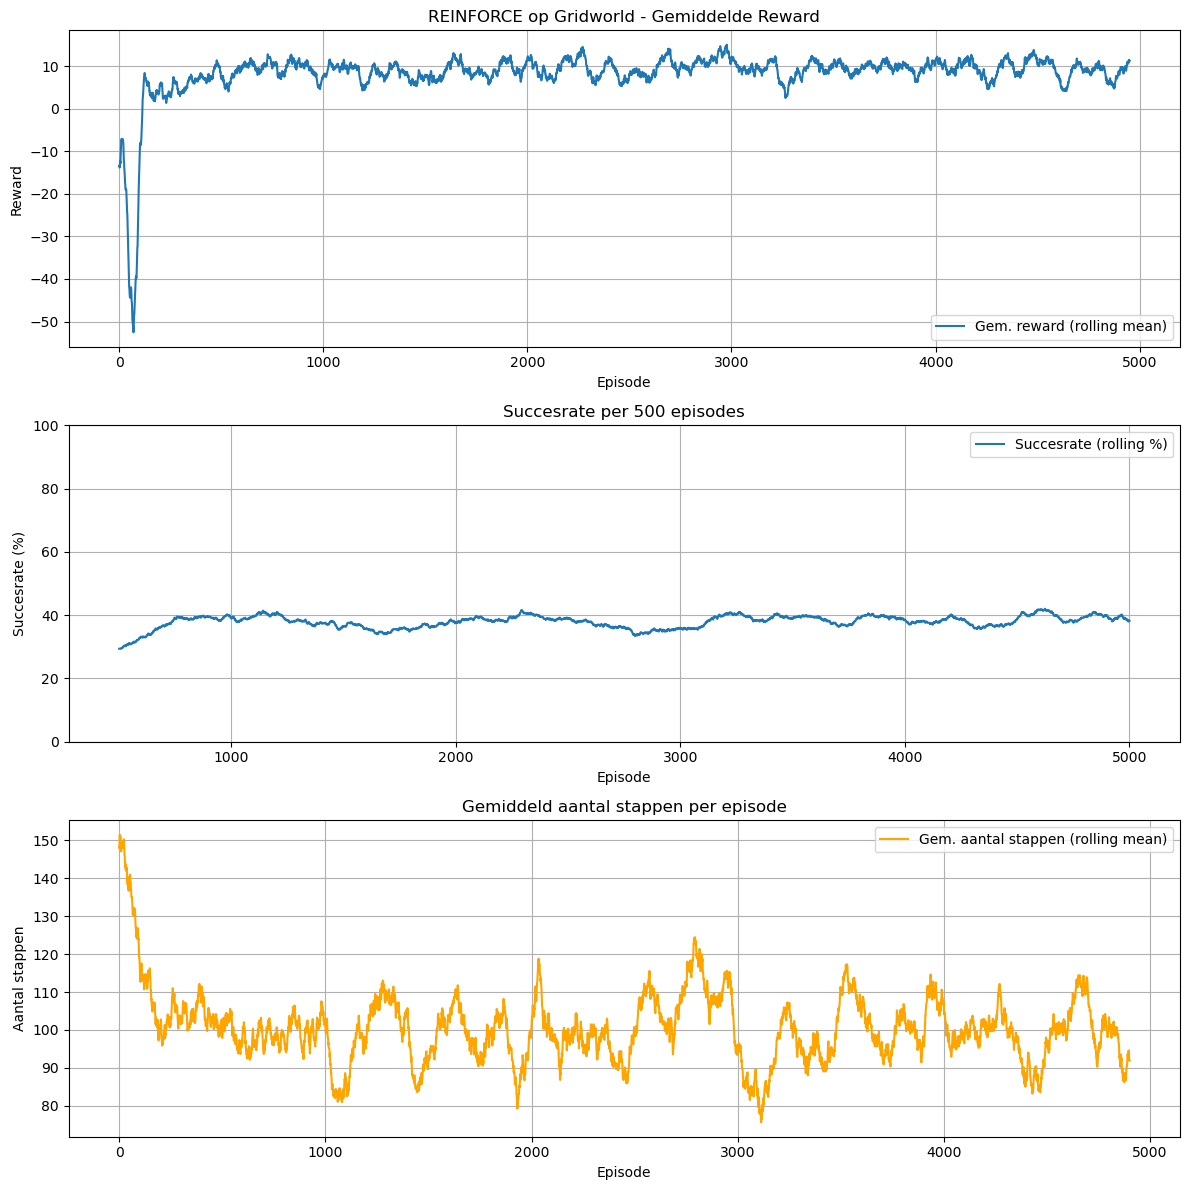

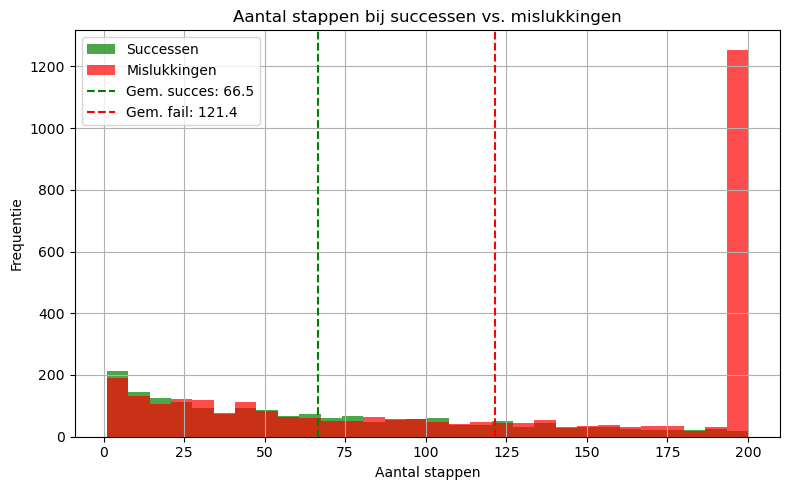

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 294300x — Herhaalpositie
  Reward 0.5: 145759x — Nieuwe positie
  Reward -1: 61081x — Niet bewogen
  Reward -10: 1915x — In pit gevallen (Pit)
  Reward 10: 1860x — Doel bereikt (Goal)

--- Gemiddelde succesrate: 37.20% over 5000 episodes


In [5]:
# Test de getrainde agent in de omgeving
print("\n--- Test baseline ---")
test_agent(agent, env_size=10)

# Visualiseer de resultaten van de training (incl. stappen)
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# Maak een animatie van het pad dat de agent volgt
ani = animate_agent_path(agent, env_size=10, state_fn=dummy_state)
display(HTML(ani.to_jshtml()))

# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    10: "Doel bereikt (Goal)",
    -10: "In pit gevallen (Pit)",
    -1: "Niet bewogen",
    0.5: "Nieuwe positie",
    0.1: "Herhaalpositie"
}

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# Bereken en toon het gemiddelde succespercentage
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


Het baseline model, getraind met een constante dummy state ([[0.0]]), wist een gemiddeld succespercentage van 37.20% te behalen over 5000 episodes. De beloningsverdeling toont aan dat de agent het doel 1860 keer wist te bereiken, tegenover 1915 keer vallen in de pit. Verreweg de meeste acties betroffen herhaalde of nieuwe posities zonder directe beloning, wat wijst op een beperkte maar werkende strategie.
Hoewel het model enige leerprogressie vertoont (zoals zichtbaar in de grafiek van de gemiddelde reward en successrate), wordt de omgeving slechts oppervlakkig begrepen. Het gebrek aan omgevingsinformatie in de input leidt ertoe dat de agent geen onderscheid kan maken tussen goede en slechte posities. Hierdoor blijft de performance hangen rond 35–40%.

#### Verbeteringen in Iteratie 1: Gebruik van visuele state-representatie
•	In  iteratie 1 heb ik een inhoudelijke verbetering aangebracht: de state-representatie is vervangen door render_np(). In plaats van een constante dummy input zonder enige context, ontvangt de agent nu een visuele representatie van het GridWorld-bord.
•	State: render_np
•	Motivatie: De render_np output bevat ruimtelijke informatie over de omgeving, zoals de positie van het doel, de pit en de speler. Dit stelt de agent in staat om het beleid niet langer op toeval, maar op concrete observaties uit de omgeving te baseren. Hierdoor wordt het mogelijk om acties te selecteren die afhangen van de actuele situatie op het bor
Hoewel de slides van les 10 (nOLET, 2025) (gebaseerd op Deep Reinforcement Learning in Action) dit niet expliciet benadrukken, zijn policy gradient methoden in principe wél geschikt voor uiteenlopende soorten state-representaties, waaronder visuele input. Dit komt doordat ze direct een beleid (policy) leren – een mapping van toestand naar actie – zonder afhankelijk te zijn van een vooraf gedefinieerde Q-waarde of value-structuur. In de slides wordt gewerkt met numerieke statevariabelen (zoals bij CartPole), maar het gebruik van ruwe of visuele input past binnen het bredere toepassingsgebied van deze methode.


### Iteratie 1 (render_np ) * Bron

In iteratie 1 is gekozen voor een inhoudelijke verbetering van de state-representatie. In plaats van een constante dummy input gebruikt de agent nu render_np(), een numerieke representatie van de GridWorld-omgeving. Deze wordt geflattened naar een vector van 1×400 en voorzien van lichte ruis. Deze ruis helpt bij het voorkomen van dead neurons (zeker in combinatie met ReLU) en draagt mogelijk bij aan het tegengaan van overfitting.

Deze aanpak sluit aan bij de werkwijze uit hoofdstuk 3 van Deep Reinforcement Learning in Action, waar render_np() wordt gebruikt om de posities van objecten (speler, doel, putten, muren) te coderen in een 4×4×4 tensor. Door deze structuur als input te gebruiken, kan het neurale netwerk leren van de ruimtelijke samenstelling van de omgeving

In [6]:
def state_rendernp(env):
    state = env.board.render_np().reshape(1, 400) + np.random.rand(1, 400) / 10.0
    return state.astype(np.float32)

In [7]:
torch.manual_seed(2025)
np.random.seed(2025)

iter1_config = Config(env_size=10, hidden_size=128, lr=0.01, gamma=0.99, episodes=5000, max_steps=200)

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter1_config, reward_fn=reward_baseline, state_fn=state_rendernp
)


100%|██████████| 5000/5000 [02:38<00:00, 31.62it/s]


### Evaluatie Iteratie 1

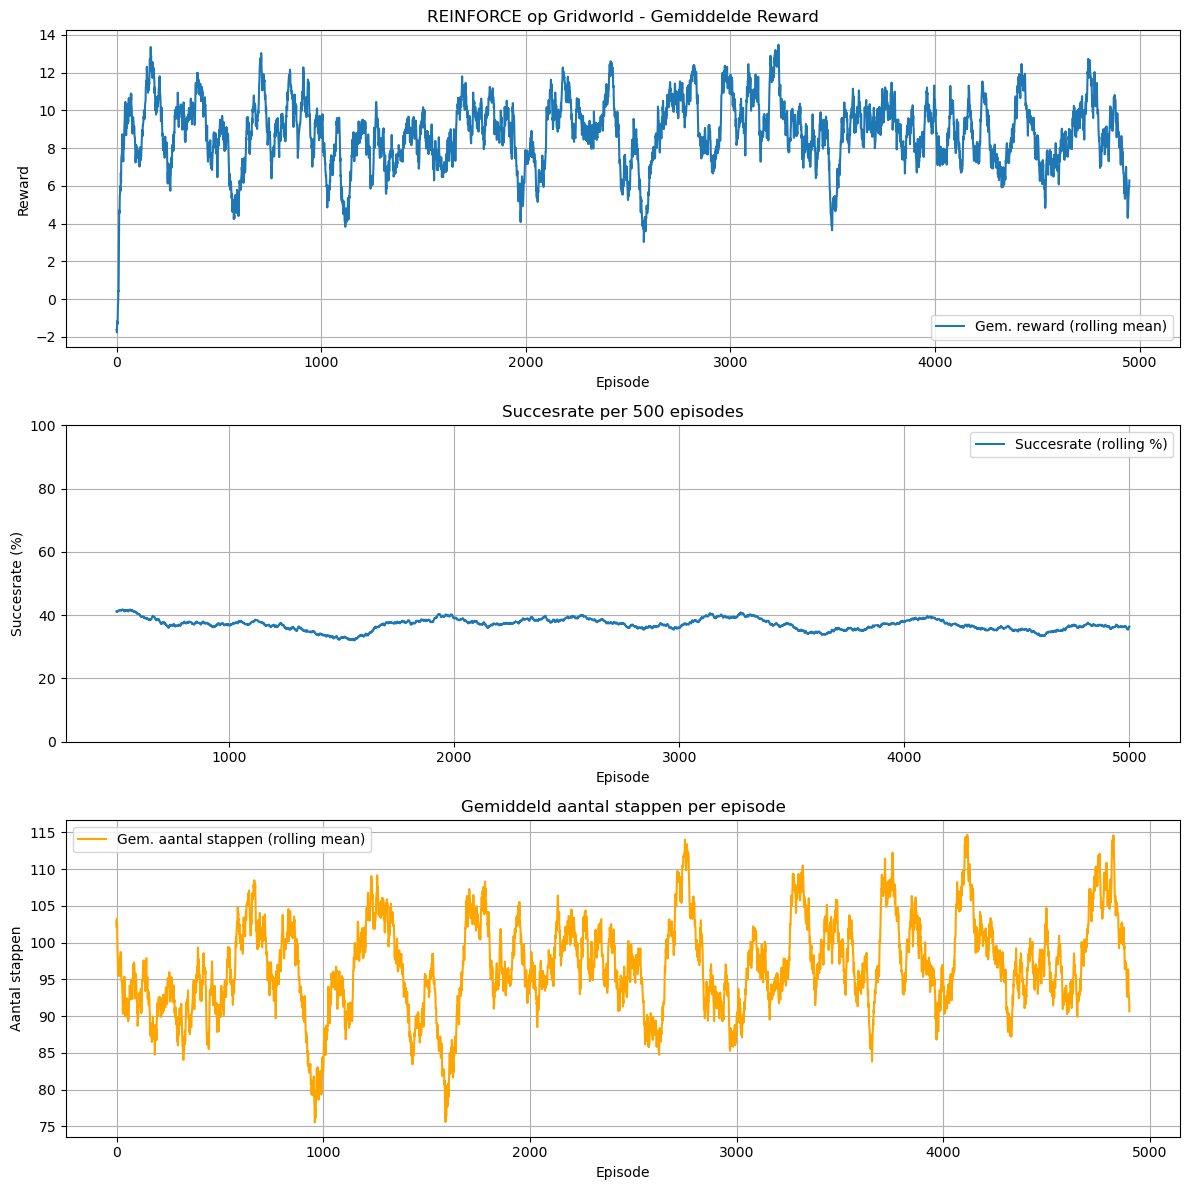

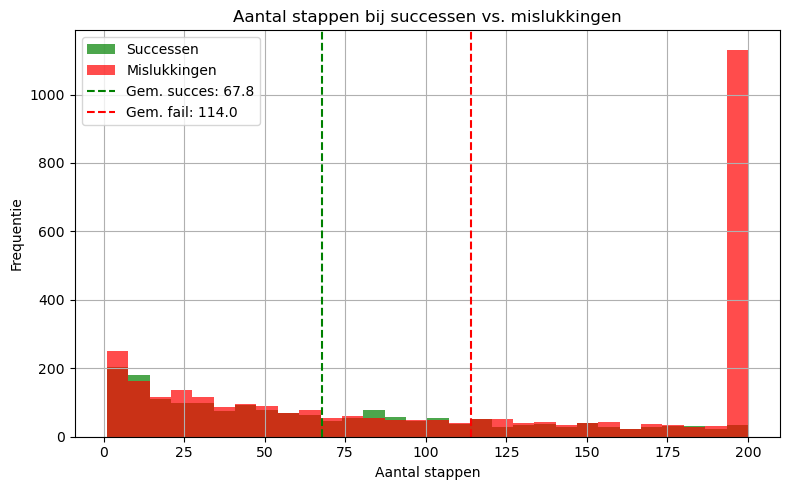

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 279970x — Herhaalpositie - baseline
  Reward 0.5: 145038x — Nieuwe positie - baseline
  Reward -1: 55144x — Niet bewogen - baseline
  Reward -10: 2033x — In pit gevallen (Pit) - baseline
  Reward 10: 1858x — Doel bereikt (Goal) - baseline

--- Gemiddelde succesrate: 37.16% over 5000 episodes


In [8]:
# Visualiseer de resultaten van de training (incl. stappen)
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# Maak een animatie van het pad dat de agent volgt
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)  # Pas aan naar juiste state_fn
display(HTML(ani.to_jshtml()))

# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie",
    10: "Doel bereikt (Goal) - baseline",
    -10: "In pit gevallen (Pit) - baseline",
    -1: "Niet bewogen - baseline",
    0.5: "Nieuwe positie - baseline",
    0.1: "Herhaalpositie - baseline"
}

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# Bereken en toon het gemiddelde succespercentage
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


De succesrate blijft steken op **37.16%**, vergelijkbaar met de baseline. De agent behaalt **1858 keer het doel**, maar valt ook **2033 keer in een pit**, wat wijst op beperkte vooruitgang. Uit de reward telling blijkt bovendien dat het grootste deel van de beloningen afkomstig is van herhaalde of inefficiënte acties (zoals **279.970 keer** een herhaalpositie).

Ook de grafieken bevestigen dit beeld: de gemiddelde reward blijft stabiel maar laag, de succesrate schommelt tussen **30–40%** en het gemiddeld aantal stappen per episode blijft relatief hoog. De agent leert dus wel, maar onvoldoende gericht op efficiënte en succesvolle trajecten.

### Volgende stap: beloningsfunctie herzien

Om de agent beter te sturen, wordt in de volgende iteratie de beloningsfunctie herschreven. Positieve uitkomsten (zoals het bereiken van het doel) krijgen een hogere beloning, terwijl ineffectieve acties (zoals stilstand of herhaling) zwaarder bestraft worden.

| Situatie           | Oude reward | Nieuwe reward |
|--------------------|-------------|----------------|
| Doel bereikt       | +10         | +100           |
| In pit gevallen    | -10         | -50            |
| Niet bewogen       | -1          | -5             |
| Nieuwe positie     | +0.5        | +1.5           |
| Herhaalpositie     | +0.1        | -0.2           |


### Iteratie 2 (Aangepast reward)

In [9]:
def reward_iter2(env, old, new, visited):
    goal = env.board.components['Goal'].pos
    pit = env.board.components['Pit'].pos

    if new == goal:
        return 100
    elif new == pit:
        return -50
    elif new == old:
        return -5
    elif new not in visited:
        return 1.5
    else:
        return -0.2


In [10]:

torch.manual_seed(2025)
np.random.seed(2025)

iter2_config = Config(env_size=10, hidden_size=128, lr=0.01, gamma=0.99, episodes=5000, max_steps=200)

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter2_config, reward_fn=reward_iter2, state_fn=state_rendernp
)



100%|██████████| 5000/5000 [02:35<00:00, 32.23it/s]


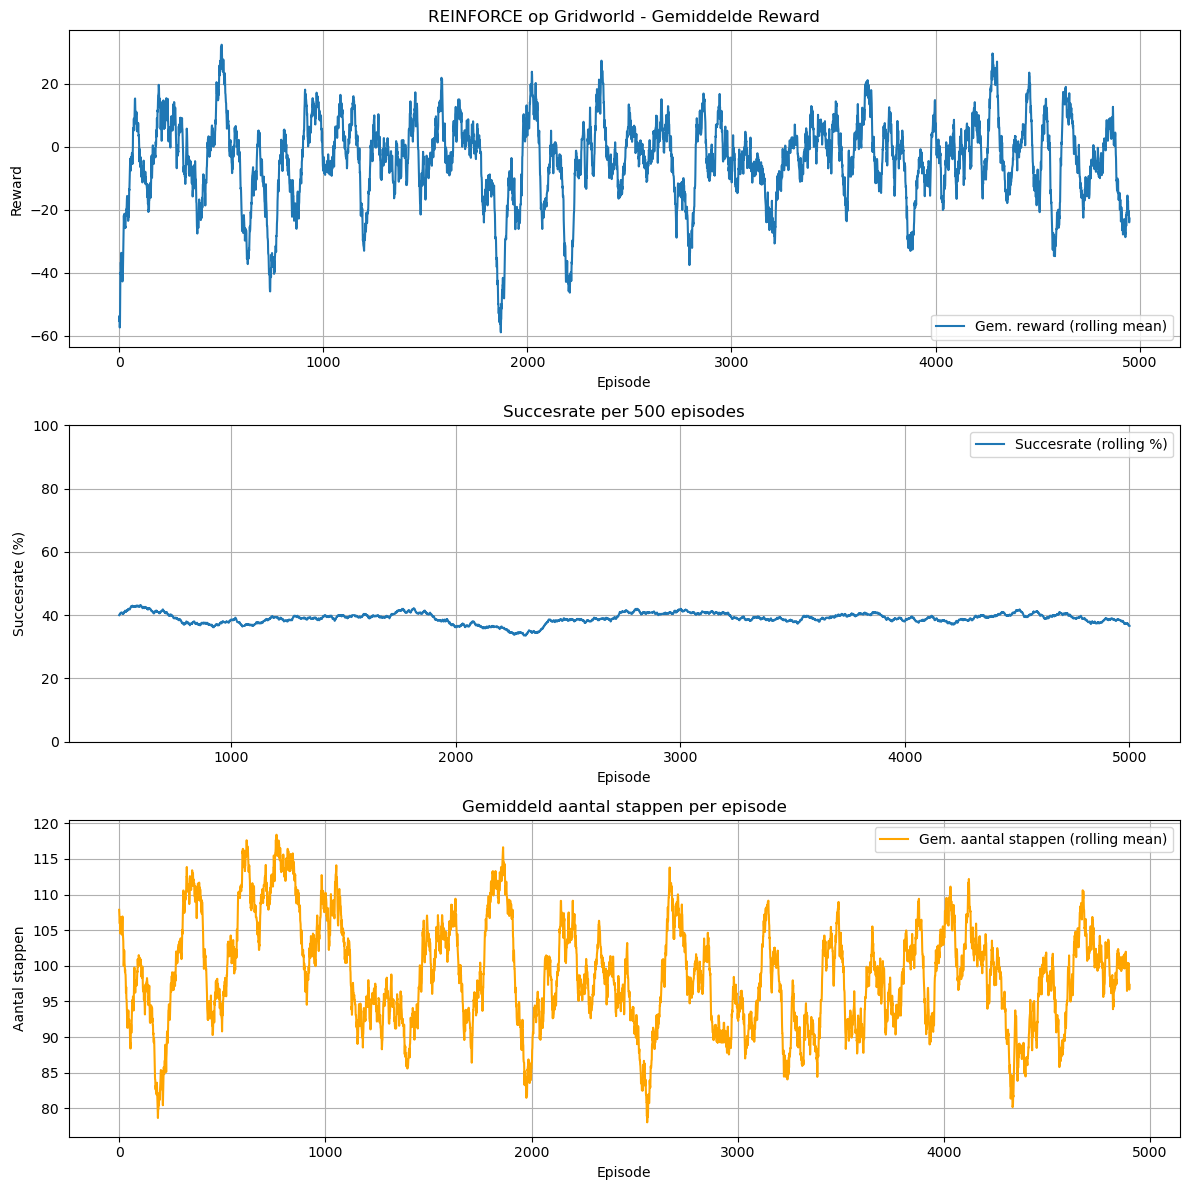

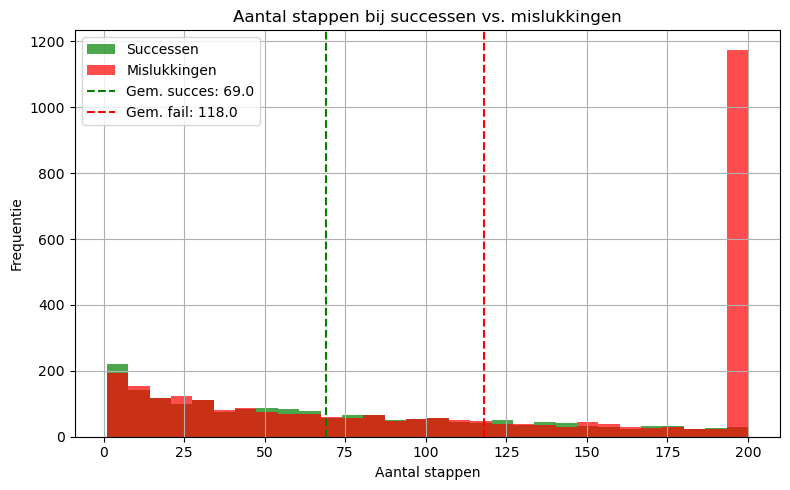

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 286865x — Herhaalpositie
  Reward 1.5: 146771x — Nieuwe positie
  Reward -5: 57204x — Niet bewogen
  Reward 100: 1946x — Doel bereikt (Goal)
  Reward -50: 1908x — In pit gevallen (Pit)

--- Gemiddelde succesrate: 38.92% over 5000 episodes


In [11]:

# Visualiseer resultaten
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# Optioneel: animatie van het pad
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

# Beloningsuitleg bij reward_iter5
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie"
}
# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie",
   
}

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# Gemiddelde succesrate
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


Op basis van de output van iteratie 2 is zichtbaar dat de aangepaste beloningen geleid hebben tot een lichte stijging in performance. De succesratio ligt nu op 38.92%, iets hoger dan in iteratie 1 (37.16%). De reward telling toont dat de agent vaker wordt beloond voor het ontdekken van nieuwe posities (1.5) en minder vaak blijft stilstaan (-5) of in herhaling vervalt (-0.2), wat betekent dat het gedrag van de agent actiever en meer verkennend is geworden.

De grafieken bevestigen dit: de gemiddelde reward schommelt, maar blijft grotendeels positief, en het gemiddeld aantal stappen per episode is stabieler. Tegelijkertijd zien we in de histogram dat successen gemiddeld minder stappen nodig hebben (69 i.p.v. 67.8), terwijl mislukte pogingen nog steeds richting de maximale limiet van 200 stappen neigen.

### Volgende stap: gamma verlagen

Hoewel het gedrag van de agent is verbeterd, zijn er tekenen van inefficiëntie in lange termijnplanning. De grafieken laten pieken en schommelingen in beloning zien, wat kan duiden op overmatige focus op toekomstige beloningen, mede door de relatief hoge gamma van 0.99.

Daarom wordt in iteratie 3 de gamma verlaagd naar 0.9. een lagere gamma zou moeten helpen om directere beloningen zwaarder te wegen, wat beter past bij een GridWorld waarin de agent relatief snel bij het doel of een valkuil kan komen. In H3 (Zai & Brown, 2020). van de literatuur wordt ook benadrukt dat een hoge gamma niet altijd optimaal is voor omgevingen met een duidelijke eindtoestand en beperkte stappen.

Mijn verwachting  is dat deze aanpassing leidt tot snellere convergentie en minder stapverspilling doordat de agent minder wordt aangetrokken tot verre toekomstbeloningen, en meer gericht is op directe verbetering.


### Iteratie 3 (lagere gamma) 

In [12]:
torch.manual_seed(2025)
np.random.seed(2025)

iter3_config = Config(env_size=10, hidden_size=128, lr=0.01, gamma=0.9, episodes=5000, max_steps=200)

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter3_config, reward_fn=reward_baseline, state_fn=state_rendernp
)


100%|██████████| 5000/5000 [02:44<00:00, 30.37it/s]


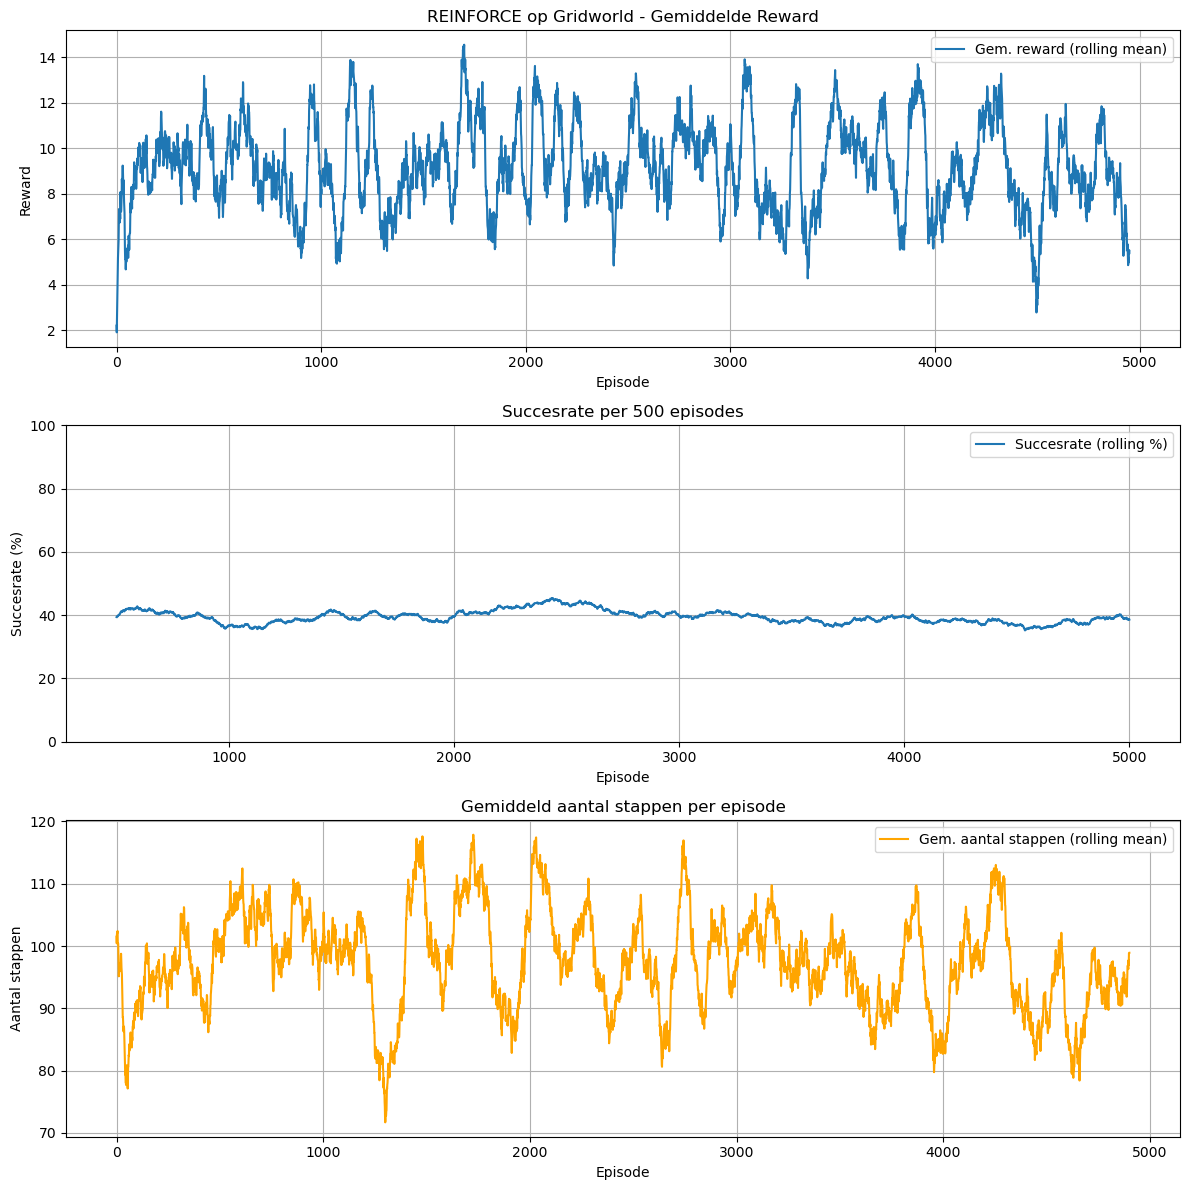

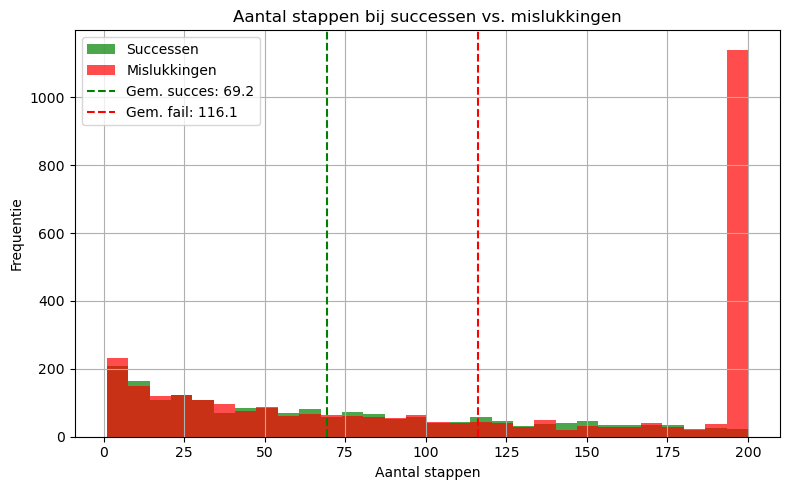

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward 0.1: 283938x — Onbekend
  Reward 0.5: 144859x — Onbekend
  Reward -1: 55725x — Onbekend
  Reward 10: 1964x — Onbekend
  Reward -10: 1922x — Onbekend

--- Gemiddelde succesrate: 39.28% over 5000 episodes


In [13]:
# --- Visualisatie van prestaties ---
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# --- Animatie van gedrag ---
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

# Beloningsuitleg bij reward_iter5
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie"
}
# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie",
   
}

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# --- Gemiddelde succespercentage ---
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")



De output van iteratie 3 toont een lichte verbetering ten opzichte van eerdere iteraties. De gemiddelde succesrate is gestegen naar 39.28%, terwijl de agent iets vaker het doel weet te bereiken (n = 1964) en iets minder vaak in een pit valt (n = 1922). Dit is een positief signaal dat de agent beter leert navigeren in de omgeving.

De gekozen aanpassing — het verlagen van de discount factor van γ = 0.99 naar γ = 0.90 — zorgt ervoor dat de agent meer nadruk legt op directe beloningen in plaats van verre toekomstbeloningen. Dit past goed bij GridWorld, waar het doel relatief dichtbij ligt en de episode een duidelijk eind heeft (doel of pit). 

De plots ondersteunen dit beeld:
- De gemiddelde reward is iets stabieler en laat een lichte stijging zien.
- De succesrate is relatief vlak, maar op een iets hoger niveau dan in eerdere iteraties.
- Het gemiddeld aantal stappen bij succes blijft stabiel rond de 69, terwijl mislukkingen rond de 116 blijven.



#### Volgende aanpassing: Maximaal aantal stappen verhogen

In iteratie 4 wordt het maximum aantal stappen verhoogd van 200 naar 800. Deze keuze is gebaseerd op de analyse van de stapverdeling (zie histogram), waaruit blijkt dat veel mislukkingen plaatsvinden rond de limiet van 200 stappen. Dit suggereert dat de agent regelmatig bezig is met een  strategie, maar simpelweg de tijd niet krijgt om deze af te maken.

Voor een 10×10 GridWorld is een limiet van 200 stappen relatief krap, zeker wanneer de agent in vroege stadia nog inefficiënt beweegt. Door deze limiet te vergroten krijgt de agent meer ruimte om te verkennen, fouten te herstellen en alsnog het doel te bereiken.



### Iteratie 4 (meer stappen mogelijk)

In [14]:

torch.manual_seed(2025)
np.random.seed(2025)

iter4_config = Config(env_size=10, hidden_size=128, lr=0.01, gamma=0.9, episodes=5000, max_steps=800) # x4

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter4_config, reward_fn=reward_iter2, state_fn=state_rendernp
)

100%|██████████| 5000/5000 [03:39<00:00, 22.73it/s]


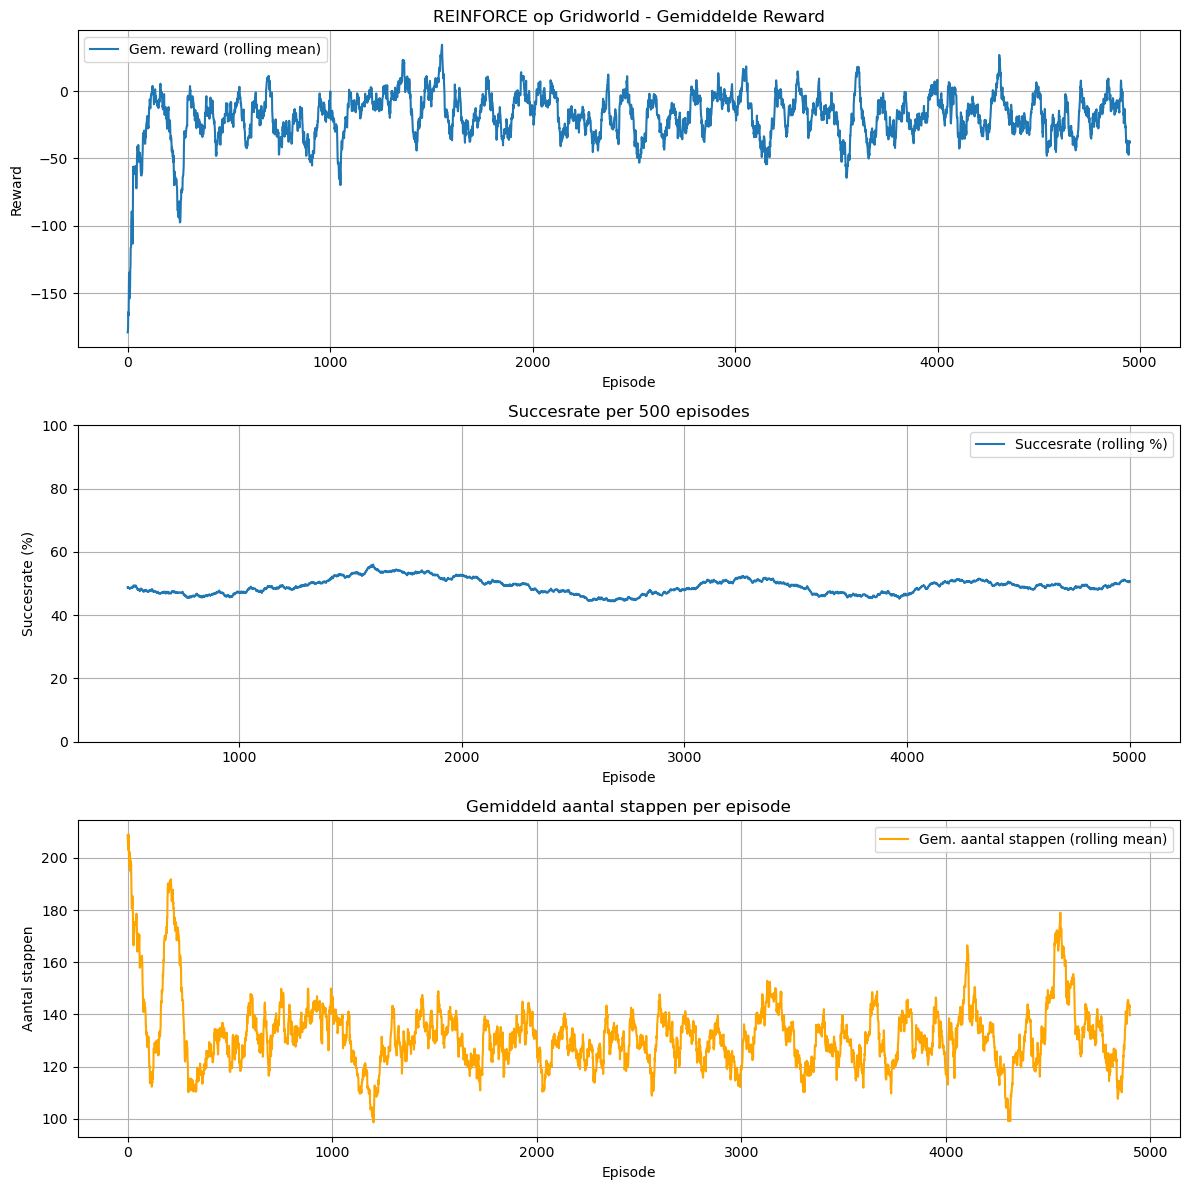

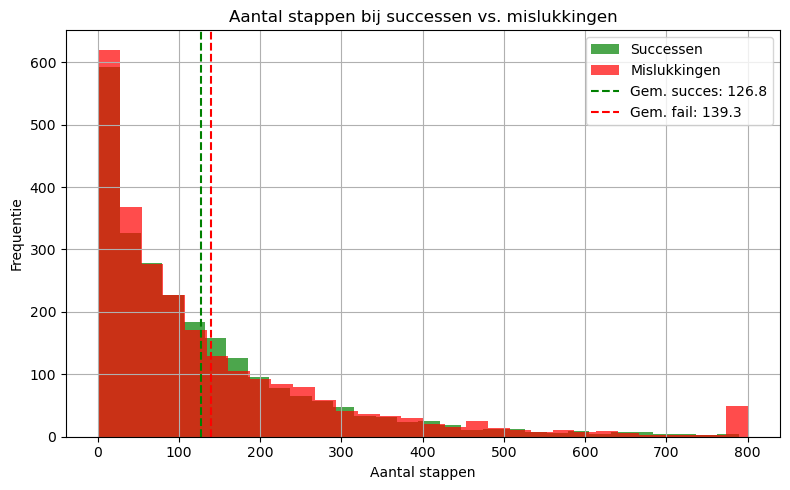

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 422010x — Herhaalpositie
  Reward 1.5: 162899x — Nieuwe positie
  Reward -5: 75900x — Niet bewogen
  Reward -50: 2493x — In pit gevallen (Pit)
  Reward 100: 2459x — Doel bereikt (Goal)

--- Gemiddelde succesrate: 49.18% over 5000 episodes


In [15]:
# Visualiseer de resultaten van de training (incl. stappen)
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# Optioneel: animatie van het pad
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie"
}
# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie",
  
}

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# Bereken en toon het gemiddelde succespercentage
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")

Iteratie 4 – Verlenging van de episodetijd
Om de agent meer tijd te geven om het doel te bereiken, heb ik het maximaal aantal stappen per episode verhoogd van 200 naar 800. Dit bleek effectief: de gemiddelde succesrate steeg van ~39% naar 49%, en het aantal succesvolle doelen nam toe. Ook het gemiddeld aantal stappen bij successen (126.8) toont aan dat de agent daadwerkelijk gebruikmaakt van de extra ruimte. De reward-plot laat iets meer negatieve pieken zien, waarschijnlijk door extra mislukte pogingen, maar de overall trend is positiever dan in eerdere iteraties.

#### In iteratie 5 
De learning rate is verlaagd van 0.01 naar 0.001, een waarde die ook wordt gebruikt in de voorbeelden uit les 10 (Nolet 2025). Deze aanpassing sluit aan bij gangbare praktijken in deep learning, waar kleinere updates per stap vaak bijdragen aan een geleidelijker en stabieler leerproces.



### Iteratie 5 (aangepaste learning rate)

In [16]:
torch.manual_seed(2025)
np.random.seed(2025)

iter5_config = Config(env_size=10, hidden_size=128, lr=0.001, gamma=0.9, episodes=5000, max_steps=800)

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter5_config, reward_fn=reward_iter2, state_fn=state_rendernp
)


100%|██████████| 5000/5000 [03:02<00:00, 27.32it/s]


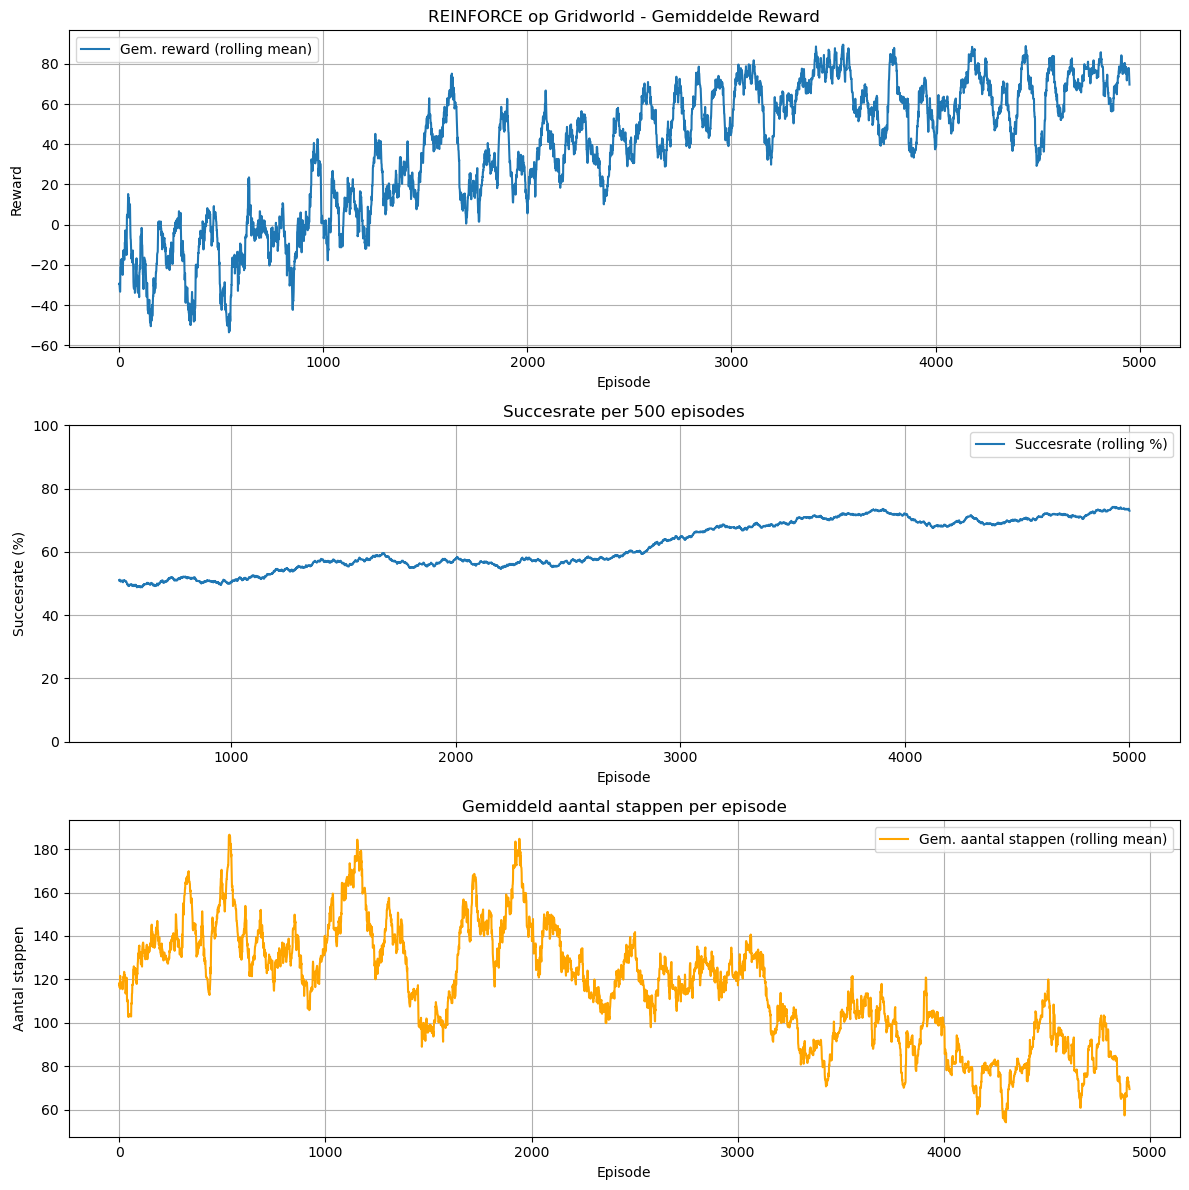

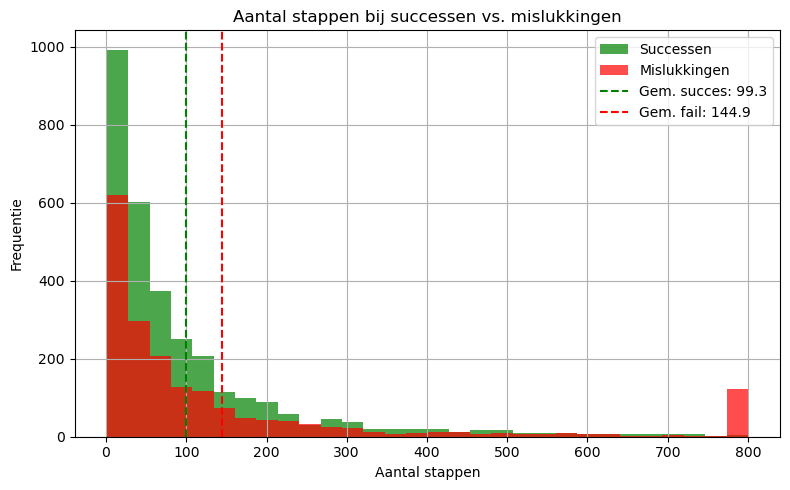

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 416212x — Herhaalpositie
  Reward 1.5: 131863x — Nieuwe positie
  Reward -5: 29901x — Niet bewogen
  Reward 100: 3106x — Doel bereikt (Goal)
  Reward -50: 1773x — In pit gevallen (Pit)

--- Gemiddelde succesrate: 62.12% over 5000 episodes


In [17]:
# Visualiseer resultaten
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# Optioneel: animatie
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

# Toon beloningentelling
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie"
}

# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie",
    }

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# Gemiddelde succespercentage
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")

De resultaten van iteratie 5, waarin de learning rate werd verlaagd van 0.01 naar 0.001, laten duidelijke verbeteringen zien ten opzichte van eerdere iteraties:

- De gemiddelde succesrate stijgt naar 62.12%, het hoogste tot nu toe behaald.
- De grafiek van de gemiddelde reward toont een duidelijke opwaartse trend, met een consistente stijging in de loop van de training.
- Ook de succesrate per 500 episodes vertoont een geleidelijke toename, wat duidt op stabieler gedrag.
- Het gemiddeld aantal stappen per episode neemt langzaam af, wat aangeeft dat de agent efficiëntere paden leert naar het doel.
- De histogram laat zien dat succesvolle episodes gemiddeld minder stappen vereisen dan mislukkingen (99 vs. 145).

De reward telling bevestigt dat het model in deze iteratie vaker het doel bereikt (3106 keer) en minder vaak in de pit valt (1773 keer), terwijl de straf voor niet bewegen sterk is afgenomen vergeleken met eerdere iteraties.

In deze iteratie is het aantal trainingsepisodes verhoogd van 5.000 naar 40.000. Reden hiervoor is de duidelijke stijgende lijn in beloning en succespercentage in iteratie 5. Door langer te trainen krijgt het model meer kans om te stabiliseren en consistent gedrag aan te leren.

Uit de grafieken blijkt dat de gemiddelde reward aanzienlijk is gestegen en de succesrate zich richting 70% beweegt. Ook daalt het gemiddeld aantal stappen per succesvolle episode naar ongeveer 90. De spreiding in de histogram toont meer geconcentreerde successen en minder mislukte runs.

De reward telling ondersteunt dit beeld.


### Iteratie 6 (Max episodes verhoogd)

In [ ]:
torch.manual_seed(2025)
np.random.seed(2025)

iter6_config = Config(
    env_size=10,
    hidden_size=128,
    lr=0.001,
    gamma=0.9,
    episodes=40000,   # ← verhoogd van 5000 naar 40000
    max_steps=500   
)

agent, scores, wins, reward_stats, steps_log, success_steps, fail_steps = train_agent(
    iter6_config,
    reward_fn=reward_iter2,   
    state_fn=state_rendernp
)



100%|██████████| 40000/40000 [12:29<00:00, 53.37it/s] 


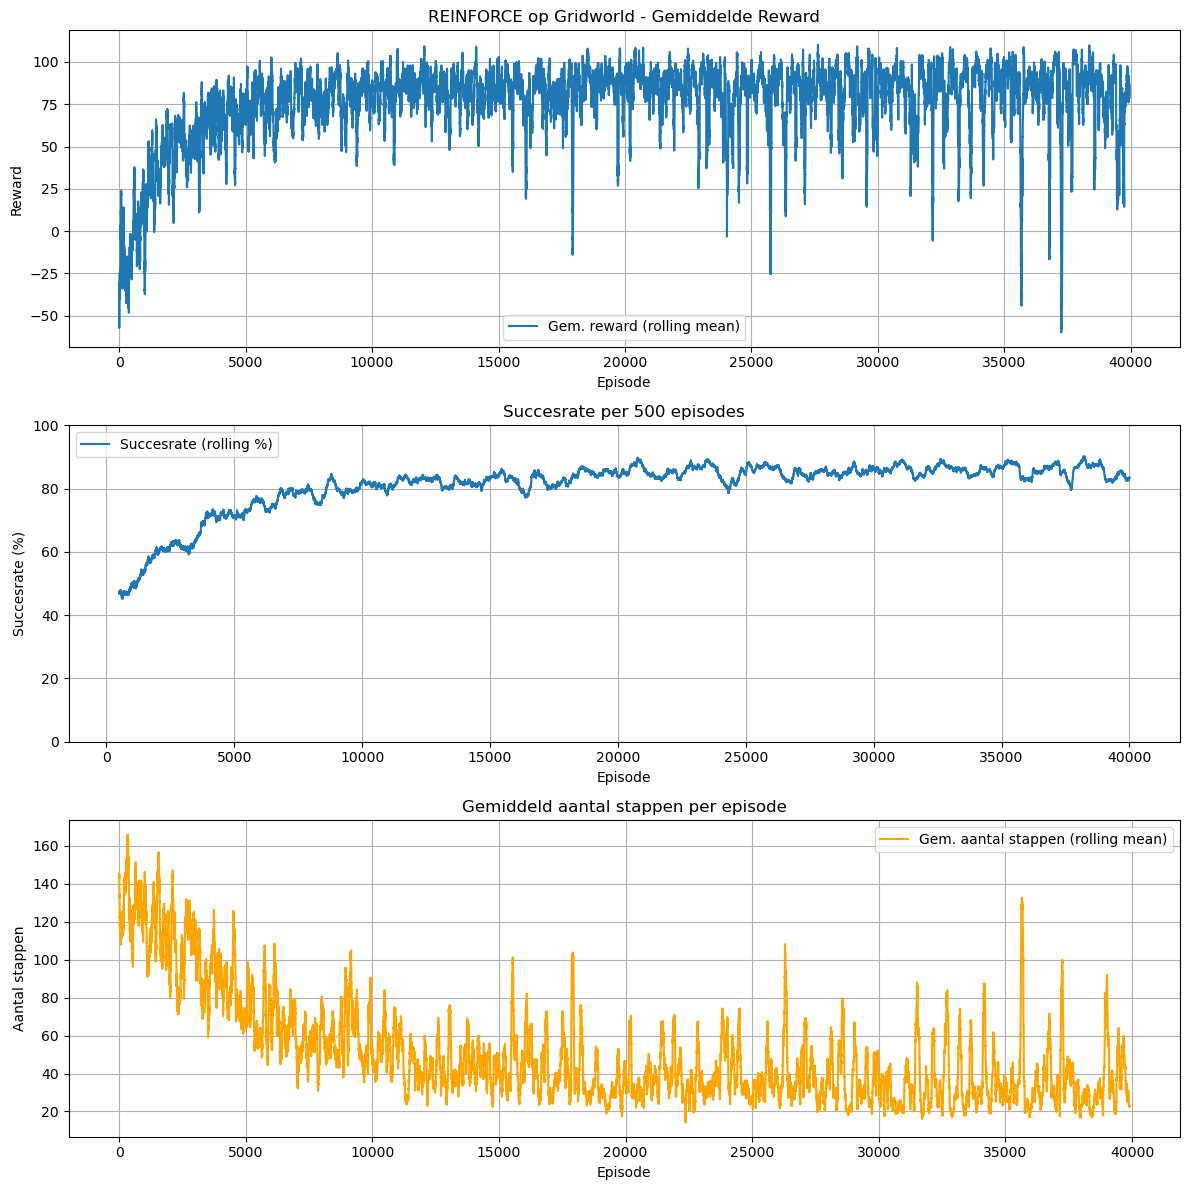

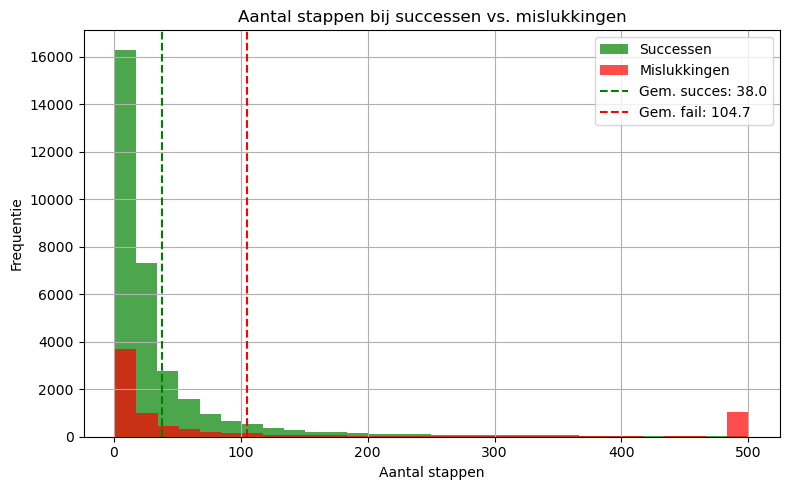

C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])
C:\Users\dylan\AppData\Local\Temp\ipykernel_32520\826800181.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_dot.set_data(pos[0], pos[1])



--- Reward telling ---
  Reward -0.2: 1326129x — Herhaalpositie
  Reward 1.5: 574691x — Nieuwe positie
  Reward -5: 92802x — Niet bewogen
  Reward 100: 32332x — Doel bereikt (Goal)
  Reward -50: 6638x — In pit gevallen (Pit)

--- Gemiddelde succesrate: 80.83% over 40000 episodes


In [19]:
# Visualiseer resultaten
plot_results(scores, wins, steps_log)
plot_success_fail_steps(success_steps, fail_steps)

# Optioneel: animatie
ani = animate_agent_path(agent, env_size=10, state_fn=state_rendernp)
display(HTML(ani.to_jshtml()))

# Beloningsuitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie"
}
# Toon statistieken over de beloningen met uitleg
reward_descriptions = {
    100: "Doel bereikt (Goal)",
    -50: "In pit gevallen (Pit)",
    -5: "Niet bewogen",
    1.5: "Nieuwe positie",
    -0.2: "Herhaalpositie",
    
}

print("\n--- Reward telling ---")
for reward_value, count in sorted(reward_stats.items(), key=lambda x: -x[1]):
    desc = reward_descriptions.get(reward_value, "Onbekend")
    print(f"  Reward {reward_value}: {count}x — {desc}")

# Succespercentage
mean_successrate = np.mean(wins) * 100
print(f"\n--- Gemiddelde succesrate: {mean_successrate:.2f}% over {len(wins)} episodes")


In iteratie 6 is het aantal trainings-episodes verhoogd van 5000 naar 40.000, met als doel de eerder waargenomen stijgende leercurve door te trekken. Dit blijkt effectief: de gemiddelde succesrate is gestegen naar 80.83% over de volledige trainingsperiode.

De bijbehorende grafieken tonen een duidelijke verbetering ten opzichte van eerdere iteraties:

- De gemiddelde reward stijgt gestaag tot boven de 90.
- De succesrate per 500 episodes groeit consistent en blijft stabiel rond de 80–90%, wat duidt op betrouwbare prestaties.
- Het gemiddeld aantal stappen per episode daalt significant en stabiliseert onder de 40, wat wijst op efficiëntere routes naar het doel.

De histogram laat zien dat het merendeel van de successen binnen 38 stappen wordt behaald, terwijl de meeste mislukkingen gemiddeld pas rond stap 105 optreden. Dit verschil ondersteunt de conclusie dat het agent-gedrag niet op toeval berust, maar op daadwerkelijk geleerde strategieën. De agent maakt minder fouten, vermijdt valkuilen en bereikt het doel efficiënter dan in eerdere iteraties.


### Test


In deze testfase heb ik mijn getrainde model geëvalueerd over 100 nieuwe episodes in een willekeurige GridWorld-omgeving. Hiervoor gebruikte ik de functie test_multiple_models, waarmee ik inzicht krijg in het aantal successen, pit deaths, timeouts, en het gemiddelde aantal stappen en beloning. Ook laat de test zien in welke gevallen de agent vroegtijdig faalde.

In [51]:
def test_multiple_models(agent, n=100, **kwargs):
    wins = 0
    losses = 0
    unfinished = 0
    total_rewards = 0
    total_steps = 0
    pit_failures = []

    for i in range(n):
        result = test_model(agent, **kwargs)
        if result[0] is None:
            unfinished += 1
        elif result[0] is False:
            losses += 1
            if len(pit_failures) < 3:
                pit_failures.append((i, result))
        else:
            wins += 1

        total_rewards += result[1]
        total_steps += result[2]

    print(f"\nResultaten over {n} testepisodes:")
    print(f"Succesrate:      {wins / n * 100:.1f}%")
    print(f"Pit deaths:      {losses / n * 100:.1f}%")
    print(f"Timeouts:        {unfinished / n * 100:.1f}%")
    print(f"Gem. reward:     {total_rewards / n:.2f}")
    print(f"Gem. episode len:{total_steps / n:.1f}")

    if pit_failures:
        print("\nEerste 3 pit failures:")
        for idx, fail in pit_failures:
            print(f"  Episode {idx} | Reward: {fail[1]:.2f} | Steps: {fail[2]}")

    return {
        'successrate': wins / n,
        'pit_deaths': losses / n,
        'timeouts': unfinished / n,
        'mean_reward': total_rewards / n,
        'mean_steps': total_steps / n
    }


In [52]:
test_multiple_models(agent, n=100, env_size=10, max_steps=800, state_fn=state_rendernp, reward_fn=reward_iter2)




Resultaten over 100 testepisodes:
Succesrate:      86.0%
Pit deaths:      12.0%
Timeouts:        2.0%
Gem. reward:     25.15
Gem. episode len:43.9

Eerste 3 pit failures:
  Episode 6 | Reward: -36.40 | Steps: 18
  Episode 29 | Reward: -35.80 | Steps: 15
  Episode 39 | Reward: -44.40 | Steps: 7


{'successrate': 0.86,
 'pit_deaths': 0.12,
 'timeouts': 0.02,
 'mean_reward': 25.154999999999887,
 'mean_steps': 43.94}

De resultaten zijn positief: de agent behaalt een succesrate van 86%, met slechts 12% pit deaths en 2% timeouts. De gemiddelde reward ligt op 25.15 en de agent doet gemiddeld 43.9 stappen per episode. Dit is een flinke verbetering ten opzichte van eerdere iteraties.

Deze output laat zien dat het model nu echt geleerd heeft in plaats van op geluk te presteren. De meeste fails ontstaan nog vroeg in de episode door vallen in een pit, maar over het algemeen navigeert de agent stabiel en efficiënt.

## Discussie en Conclusie

In deze opdracht heb ik een reinforcement learning model gebouwd op basis van de REINFORCE policy gradient methode. Ik begon met een simpel baseline-model zonder inputinformatie (dummy state), en werkte in zes iteraties toe naar een model dat succesvol leert navigeren in een willekeurige 10 × 10 GridWorld-omgeving.

Elke iteratie bracht één gecontroleerde wijziging aan: van visuele input en beloningsstructuur tot hyperparameters zoals gamma, learning rate en aantal episodes. Hierdoor kon ik gericht analyseren wat het effect was van elke keuze. De uiteindelijke versie (iteratie 6) behaalt een succesrate van boven de 80% over 40.000 episodes. De grafieken laten zien dat deze prestatie structureel is en niet op toeval berust. Dit model voldoet dan ook aan de opdracht en is een goed voorbeeld van een iteratief ontwikkelde policy gradient-oplossing.

Wel zijn er een paar aandachtspunten. Zo gebruikte ik een dense netwerk met render_np input. Een convolutioneel netwerk zou mogelijk beter omgaan met visuele input, doordat het ruimtelijke structuren efficiënter verwerkt. 

Ook is de schaalbaarheid van dit model naar grotere of complexere omgevingen niet getest. Een logische vervolgstap zou zijn om extra domeinspecifieke kennis toe te voegen, bijvoorbeeld in de vorm van een shaping reward op basis van de Manhattan distance tot het doel. Daarnaast zou het verhogen van het aantal neuronen of het toevoegen van convolutionele lagen de verwerkingscapaciteit kunnen verbeteren in grotere omgevingen.



### Succespercentages per iteratie

| Iteratie    | Succesrate (%) | Wijziging                                                  |
|-------------|----------------|-------------------------------------------------------------|
| Baseline    | 37.20          | Dummy state, standaard reward                               |
| Iteratie 1  | 37.16          | Invoervorm gewijzigd naar render_np                        |
| Iteratie 2  | 38.92          | Beloningsfunctie herschreven (meer verschil tussen acties) |
| Iteratie 3  | 39.28          | Discount factor gamma verlaagd van 0.99 naar 0.9           |
| Iteratie 4  | 49.18          | Maximaal aantal stappen verhoogd naar 800                  |
| Iteratie 5  | 62.12          | Learning rate verlaagd van 0.01 naar 0.001                 |
| Iteratie 6  | 80.83          | Aantal episodes verhoogd van 5.000 naar 40.000             |
| Test (n=100)| 86.00          | Evaluatie van eindmodel in nieuwe omgevingen               |


### Referenties

Nolet, R. (2025). *RL – Les 10: Policy Gradient Methods*. Retrieved from de onderwijsomgeving van HVA. 
Nolet, R. (2025). *RL – Les 9: Deep Q Networks*. Retrieved from de onderwijsomgeving van HVA.


Zai, A., & Brown, B. (2020). *Deep Reinforcement Learning in Action*. Shelter Island, NY: Manning Publications.
